In [8]:
from typing import Optional, Dict
from scipy.signal import sawtooth

import pandas as pd
import numpy as np
import os
import json
from pathlib import Path
from typing import Tuple
from collections import defaultdict
import ruamel.yaml
from typing import Union
from tkinter import filedialog
import tkinter as tk
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
import matplotlib as mpl
from scipy.interpolate import UnivariateSpline
from scipy import signal


In [9]:


class SpEC:
    """
    The SpEC class is used to store and manipulate spectral and CV data. Using SpEC you can:
    - Read CV data
    - Read spectral data
    - Calibrate spectral data to the CV data
    - Break apart CV and spectral data into indivual linear sweeps
    - Downsample spectral data that is recorded at very high frame rates and wavelength resolutions to obtain highly averaged dataframes
    """
    def __init__(
        self,
        Andorspec: Optional[pd.DataFrame] = None,
        CV: Optional[pd.DataFrame] = None,
        interpolation: Optional[tuple] = None,
        spec_scans: Optional[Dict] = None,
        CV_scans: Optional[Dict] = None,
    ):
        self.Andorspec = Andorspec if Andorspec is not None else pd.DataFrame()
        self.CV = CV if CV is not None else pd.DataFrame()
        self.interpolation = interpolation if interpolation is not None else {}
        self.spec_scans = spec_scans if spec_scans is not None else {}
        self.CV_scans = CV_scans if CV_scans is not None else {}
    
    
    ## Reader class methods


    def read_CV(self,
                path: str,
                 default_U_header:str='Ewe_V',
                 default_t_header:str='t_s',
                 default_cycle_header:str='cycle',
                 default_current_header:str='I_A',
                 return_additional_headers:list[str]=None,
                 return_metadata:bool=False):
        """This function reads a CV.hlo file and returns a pandas dataframe with the data"""
        self.CV = read_CV_hlo(path,
                    default_U_header,
                    default_t_header,
                    default_cycle_header,
                    default_current_header,
                    return_additional_headers,
                    return_metadata)
        
    def read_spec_parquet(self, path: str):
        """This function reads a parquet file and returns a pandas dataframe with the data"""
        self.Andorspec = pd.read_parquet(path)


    def populate_interpolation(self, path:str):
        """Import the interpolation data from a .json file"""
        with open(path) as f:
            data_dict = json.load(f)
            self.interpolation = tuple(data_dict.values())
        return self.interpolation   

    # scan manipulation methods - these methods are used to break apart the CV and spectral data into individual scans

    def populate_spec_scans(self, cycle_header: str='cycle', direction_header:str='direction', time_header:str='t_s'):
        """This function reads the Andorspec attribute of the SpEC object. It uses pandas groupby operations
        to group the data by cycle and then by scan direction. It then populates the spec_scans attribute of the SpEC
        object with a dictionary of dictionaries. The first key is the cycle number, the second key is the scan direction.
        The value is the dataframe of the spectral data for that cycle and scan direction.
        
        inputs: self
        outputs: self.spec_scans: Dict
        """

        cycle_dict = {}
        for i in range(int(self.Andorspec[cycle_header].max() + 1)):
            try:
                temp = self.Andorspec.groupby([cycle_header]).get_group((i,))
            except Exception as e:
                print(f"no data in cycle number {i}, {e} scan data set to None")
                temp = {}
                continue
            try:
                Anodic = (
                    temp.groupby([direction_header])
                    .get_group(("anodic",))
                    .drop(direction_header, axis=1)
                    .drop(cycle_header, axis=1)
                    .drop(time_header, axis=1))
                Anodic.index=Anodic['Ewe_V'].astype(float)
                Anodic.drop(columns=['Ewe_V'],inplace=True)
                Anodic=Anodic.T
                Anodic.index=Anodic.index.astype(float)

                
            except Exception as e:
                Anodic = None
                print(f"no anodic data in scan number {i}, {e} scan data set to None")
                continue
            try:
                Cathodic = (
                    temp.groupby([direction_header])
                    .get_group(("cathodic",))
                    .drop(direction_header, axis=1)
                    .drop(cycle_header, axis=1)
                    .drop(time_header, axis=1)
                )
                Cathodic.index=Cathodic['Ewe_V']
                Cathodic.drop(columns=['Ewe_V'],inplace=True)
                Cathodic=Cathodic.T
                Cathodic.index=Anodic.index.astype(float)
            except Exception as e:
                print(f"no cathodic data in scan number {i}, {e} scan data set to None")
                Cathodic = None
                continue
            cycle_dict[i] = {"anodic": Anodic, "cathodic": Cathodic}
        self.spec_scans = cycle_dict
        return self.spec_scans

        

    def populate_CV_scans(self, cycle_header: str='cycle', time_header:str='t_s'):
        """Like populate spec scans this function uses the derivative of the interpolation function to determine the scan direction
        of the CV data and add this to the CV. It then groups the CV data by cycle and scan direction.
        It then populates the CV_scans attribute of the SpEC object with a dictionary of dictionaries.
        The first key is the cycle number, the second key is the scan direction. The value is the dataframe
        of the CV data for that cycle and scan direction
        
        inputs: self
        outputs: self.CV_scans: Dict
        """

        cycle_dict = {}

        for i in range(int(self.CV[cycle_header].max()+1)):
            try:
                temp = self.CV.groupby([cycle_header]).get_group((i,))
            except Exception as e:
                print(f"no data in cycle number {i}, {e} scan data set to None")
                temp = {}
                continue

            try:
                deriv = np.diff(sawtooth2(temp[time_header], *self.interpolation)) > 0
                deriv = np.insert(deriv, 0, deriv[0])
                # Initialize scan_direction as an array of strings instead of zeros
                scan_direction = np.full(len(temp[time_header]), "", dtype=object)

                # Set the scan direction to 'anodic' if the derivative is greater than zero
                scan_direction[deriv] = "anodic"
                # Set the scan direction to 'cathodic' if the derivative is less than zero
                scan_direction[~deriv] = "cathodic"

                temp.insert(0, "direction", scan_direction)

            except Exception as e:
                print(
                    f"No time was found in the data of this cycle: {e}. This meant no scan direction could be calculated"
                )
                return

            try:
                Anodic = (
                    temp.groupby(["direction"])
                    .get_group(("anodic",))
                    .drop("direction", axis=1)
                    .drop("cycle", axis=1)
                        )
                    
                
            except Exception as e:
                Anodic = None
                print(f"no anodic data in scan number {i}, {e} scan data set to None")
            try:
                Cathodic = (
                    temp.groupby(["direction"])
                    .get_group(("cathodic",))
                    .drop("direction", axis=1)
                    .drop("cycle", axis=1)
                )
            except Exception as e:
                print(f"no cathodic data in scan number {i}, {e} scan data set to None")
                Cathodic = None
            cycle_dict[i] = {"anodic": Anodic, "cathodic": Cathodic}
        self.CV_scans = cycle_dict
        return self.CV_scans


def calculateDOD(
    SpEC_object: SpEC,
    cycle_number: int,
    scan_direction: str,
    Referance_potential: float,
    smooth_strength: int = 0,
):
    """This function calculates Delta OD for a single cycle and scan direction. If the referance potential
    given is not present the nearest potential is used. The function returns a dataframe. If smooth_strength is set to 0
    the function returns the raw data. If smooth_strength is an odd integer the function returns the data smoothed by a golay function
    
    inputs:
    SpEC_object: an instance of the SpEC class with spec_scans or spec_scans_downsampled populated
    cycle_number: int - the cycle number of the data you want to process
    scan_direction: str - the scan direction of the data you want to process
    Referance_potential: float - potential you wish to set Delta A to be zero at
    smooth_strength: int - the strength of the smoothing function. If set to 0 the function returns the raw data. If set to an odd integer the function returns the data smoothed by a golay function
    """
    if scan_direction not in ["anodic", "cathodic"]:
        print('scan_direction must be either "anodic" or "cathodic"')
        return

    # extract the spectral data for the cycle and scan direction

    data = SpEC_object.spec_scans[cycle_number][scan_direction]

    # extract the voltages - which are the collumn names
    voltages = data.columns.values
    # print(voltages)

    # find the nearest potential to the referance potential

    nearest_potential_index = np.argsort(np.abs((voltages - Referance_potential)))[0]

    # extract the data at the nearest potential

    I0 = data.iloc[:, nearest_potential_index]
    LnI0 = np.log10(I0)
    LnI = pd.DataFrame(np.log10(data))
    # print(LnI.shape)

    DOD = -1 * LnI.subtract(LnI0, axis=0)

    if smooth_strength != 0:
        DOD = DOD.apply(lambda x: signal.savgol_filter(x, smooth_strength, 3), axis=0)

    return pd.DataFrame(DOD), Referance_potential


def plot_DOD(
    DOD_dataframe: pd.DataFrame,
    Title: Optional[str] = None,
    y_max: Optional[float] = None,
    y_min: Optional[float] = None,
    x_max: Optional[float] = None,
    x_min: Optional[float] = None,
    reference_potential: Optional[str] = None,
):
    """This function takes in a DOD dataframe and plots it. The function returns a plot using a uniform colormap.
    
    args:
    DOD_dataframe: pd.DataFrame - a single dataframe from the spec_scans_downsampled attribute of the SpEC object
    Title: str - the title you wish the plot to have
    y_max: float - the maximum value of the y axis
    y_min: float - the minimum value of the y axis
    x_max: float - the maximum value of the x axis
    x_min: float - the minimum value of the x axis
    reference_potential: str - the reference potential of the DOD data. This only modifies the y axis label


    """
    # get the number of collumns in DOD
    n = DOD_dataframe.shape[1]
    # get the color map

    cmap = cmc.roma

    colors = cmap(np.linspace(0, 1, n))
    # remove the first 100 rows
    colors = np.linspace(0, 1, n)
    colors = cmc.roma(colors)

    fig, ax = plt.subplots()
    for i in range(n):
        ax.plot(
            DOD_dataframe.index, DOD_dataframe.iloc[:, i], color=colors[i], linewidth=2
        )

    v_min = DOD_dataframe.columns.min()
    v_max = DOD_dataframe.columns.max()
    # Normalize the color map
    norm = mpl.colors.Normalize(vmin=v_min, vmax=v_max)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Add the colorbar to the figure
    fig.colorbar(sm, ax=ax, label="$U (V) $")

    plt.xlabel("Wavelength (nm)", fontsize=21)
    # set the y label to f"$\Delta$A (O.D. vs {reference_potential} V)" if reference_potential is not None else f"$\Delta$A (O.D.)"
    plt.ylabel(
        (
            f"$\Delta$A (O.D. vs {reference_potential})"
            if reference_potential is not None
            else f"$\Delta$A (O.D.)"
        ),
        fontsize=18,
    )

    # set the axis font size to 20
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    if Title is not None:
        plt.title(Title, fontsize=21)
    if y_max is not None and y_min is not None:
        plt.ylim(top=y_max, bottom=y_min)

    if x_min is not None and x_max is not None:
        plt.xlim(left=x_min, right=x_max)

    return fig, ax




def Co_plot_DOD_and_CV(
    DOD_dataframe: pd.DataFrame,
    CV_dataframe: pd.DataFrame,
    Title: Optional[str] = None,
    y_max: Optional[float] = None,
    y2_max: Optional[float] = None,
    y_min: Optional[float] = None,
    y2_min: Optional[float] = None,
    x_max: Optional[float] = None,
    x_min: Optional[float] = None,
    reference_potential: Optional[str] = None,
    scan_direction: Optional[str] = None,
    cmap_option = cmc.roma,
    colour_bar_label: Optional[str] = None,
    ref_electrode_name: Optional[str] = None,
    referance_electrode_correction: Optional[float] = None,
):
    """This function can be used to make inital co-plots of DOD and linear sweep data. It generates a plot.

    args: 
    DOD_dataframe: pd.DataFrame - a single dataframe from the spec_scans_downsampled attribute of the SpEC object
    CV_dataframe: pd.DataFrame - a single dataframe from the CV_scans attribute of the SpEC object. Must be the same 
    cycle and scan direction as the chosen DOD_dataframe
    Title: str - the title of the plot
    y_max: float - the maximum value of the O.D axis
    y2_max: float - the maximum value of the current axis
    y_min: float - the minimum value of the O.D axis
    y2_min: float - the minimum value of the current axis
    x_max: float - the maximum value of the wavelength axis
    x_min: float - the minimum value of the wavelength axis
    reference_potential: str - the reference potential of the DOD data. This only modifies the y axis label
    scan_direction: str - the scan direction of the CV data. This only modifies the title
    cmap_option: cmc colormap - the colormap used to plot the DOD data. You can choose any colormap from cmcrameri.cm
    colour_bar_label: str - the label of the colour bar
    ref_electrode_name: str - the name of the reference electrode
    referance_electrode_correction: float - the correction factor for the referance electrode if needed
    
    
    """

    if referance_electrode_correction != None:

        correction=referance_electrode_correction

    else:
        correction=0
    

    # get the number of collumns in DOD
    n = DOD_dataframe.shape[1]
    # get the color map

    cmap = cmap_option

    colors = cmap(np.linspace(0, 1, n))
    # remove the first 100 rows
    colors = np.linspace(0, 1, n)
    colors = cmap_option(colors)

    fig, ax = plt.subplots(2, 1)

    for i in range(n):
        ax[0].plot(
            DOD_dataframe.index, DOD_dataframe.iloc[:, i], color=colors[i], linewidth=2
        )

    v_min = DOD_dataframe.columns.min()+correction
    v_max = DOD_dataframe.columns.max()+correction
    # Normalize the color map
    norm = mpl.colors.Normalize(vmin=v_min+correction, vmax=v_max+correction)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Add the colorbar to the figure
    if colour_bar_label == None:
        fig.colorbar(sm, ax=ax[0], label="$U (V) $")
    else:
        fig.colorbar(sm, ax=ax[0], label=colour_bar_label)

    ax[0].set_xlabel("Wavelength (nm)", fontsize=12)
    # set the y label to f"$\Delta$A (O.D. vs {reference_potential} V)" if reference_potential is not None else f"$\Delta$A (O.D.)"
    ax[0].set_ylabel(
        (
            f"$\Delta$A (O.D. vs {reference_potential})"
            if reference_potential is None
            else f"$\Delta$A (O.D.)"
        ),
        fontsize=12,
    )

    # set the axis font size to 20
    # ax[0].set_xticks(fontsize=18)
    # ax[0].set_yticks(fontsize=18)
    # set the axis fontsixe

    if Title is not None:
        fig.suptitle(Title, fontsize=21)
    if y_max is not None and y_min is not None:
        ax[0].set_ylim(top=y_max, bottom=y_min)

    if x_min is not None and x_max is not None:
        ax[0].set_xlim(left=x_min, right=x_max)

    # ax[1].plot(CV_dataframe['Ewe_V'], CV_dataframe['I_A'])

    # extract the voltage and current data from the CV dataframe as a new dataframe
    CV = CV_dataframe[["Ewe_V", "I_A"]]
    num_points = CV.shape[0]  # Assuming CV is a list or array of points
    cmap = cmap_option

    colors = cmap(np.linspace(0, 1, num_points))
 

    for i in range(num_points - 2):
        if scan_direction is not None and scan_direction == "anodic":
            ax[1].plot(CV.iloc[i : i + 2, 0]+correction, CV.iloc[i : i + 2, 1], color=colors[i])
        elif scan_direction is not None and scan_direction == "cathodic":
            ax[1].plot(CV.iloc[i : i + 2, 0]+correction, CV.iloc[i : i + 2, 1], color=colors[-i])

    ax[1].set_xlabel("U ($V$)", fontsize=12)

    if y2_min is not None and y2_max is not None:
        ax[1].set_ylim(top=y2_max, bottom=y2_min)

    ax[1].set_ylabel("J (A$cm^{2}$)", fontsize=12)
    if scan_direction is not None and scan_direction == "anodic":
        ax[1].annotate(
            "Scan direction",
            xy=(0.5, 1.08),
            xytext=(0.3, 1.08),
            arrowprops=dict(facecolor="black", arrowstyle="->"),
            ha="center",
            va="center",
            fontsize=16,
            xycoords="axes fraction",
            textcoords="axes fraction",
        )
    if scan_direction is not None and scan_direction == "cathodic":
        ax[1].annotate(
            "Scan direction",
            xy=(0.3, 1.08),
            xytext=(0.5, 1.08),
            arrowprops=dict(facecolor="black", arrowstyle="->"),
            ha="center",
            va="center",
            fontsize=16,
            xycoords="axes fraction",
            textcoords="axes fraction",
        )

    # ax[1].xticks(fontsize=18)

    # ax[1].yticks(fontsize=18)

    # use tight layout to prevent overlap of the two plots
    plt.tight_layout()
    plt.show()



def normalise_DOD(DOD_dataframe: pd.DataFrame, by_max: bool = True):
    """This function takes in a DOD dataframe and normalises it to the maximum value of each collumn. The function returns a normalised DOD dataframe
    The by max flag can be set to False to normalise to the minimum value of each  - good for negative data"""
    # write a lambda fucnction that normalises each collumn of a dataframe by the maximum value of that collumn
    if by_max:
        normalise = lambda x: x / x.max()
    else:
        normalise = lambda x: x / x.min()
    # apply the normalise function to the DOD dataframe
    DOD_normalised = DOD_dataframe.apply(normalise, axis=0)

    return DOD_normalised


def select_spectrum_at_nearest_voltage(
        DOD_dataframe: pd.DataFrame,
        voltage: float
):
    """This function takes in a DOD dataframe and selects the spectrum
      at the nearest voltage to the voltage given. 
      The function returns a single spectrum as a dataframe
      
        inputs: DOD_dataframe - a downsamples dataframe converted to Delta O.D
        voltage - the voltage you want to select the spectrum at

        outputs: a single spectrum as a dataframe
      """
    # get the number of collumns in DOD
    n = DOD_dataframe.shape[1]
    # get the color map

    voltages = DOD_dataframe.columns.values
    nearest_potential_index = np.argsort(np.abs((voltages - voltage)))[0]

    return DOD_dataframe.iloc[:, nearest_potential_index]

def downsample_spectra_for_differential_analysis(
        DOD_dataframe: pd.DataFrame,
        voltage_step: float):
    """
    This function takes in a DOD dataframe and a dataframe of spectra every voltage
    step using the select_spectrum_at_nearest_voltage function. The function returns a downsampled dataframe

    inputs: DOD_dataframe - a downsamples dataframe converted to Delta O.D
    voltage_step - the voltage step you want to extract every spectrum at

    outputs: a downsampled dataframe
    """

    voltages = DOD_dataframe.columns.values

    # create a list of the voltages you want to extract the spectra at

    voltages_to_extract = np.arange(voltages.min(), voltages.max(), voltage_step)

    # create an empty dictionary to store the spectra and their voltages

    spectra_dict = {}

    # iterate through the voltages to extract the spectra

    for voltage in voltages_to_extract:
        spectra_dict[voltage] = select_spectrum_at_nearest_voltage(DOD_dataframe, voltage)

    # convert the dictionary to a dataframe

    downsampled_spectra = pd.DataFrame(spectra_dict)

    return downsampled_spectra

def calculate_differential_spectra(
    DOD_dataframe: pd.DataFrame,
    voltage_step: float,
    smooth_strength: int = 0,
    Normalise: bool = True,):
    """
    This function takes in a DOD dataframe and a voltage step. 
    It uses the downsample_spectra_for_differential_analysis 
    function to extract the spectra at every voltage step.
    It then applies np.diff on the collumns of the downsampled dataframe.
    If the smooth_strength is greater than 0 it applies a 
    savgol filter to the data of the desired strength. If Normalise is set to True
    the function normalises the data to the maximum value of each collumn.
    """

    downsampled_spectra = downsample_spectra_for_differential_analysis(DOD_dataframe, voltage_step)

    # get the minimum value of the collumns of the downsampled dataframe

    # min_U = downsampled_spectra.columns.min()

    differential_spectra = downsampled_spectra.diff(axis=1)

    

    #insert a collumn of zeros with the same length as the first collumn of the dataframe   
    #differential_spectra.insert(0, min_U, np.zeros(differential_spectra.shape[0]))
    
    if smooth_strength != 0:

        differential_spectra = differential_spectra.apply(lambda x: signal.savgol_filter(x, smooth_strength, 3), axis=0)

    if Normalise:
        differential_spectra = normalise_DOD(differential_spectra)

    return differential_spectra

def fit_current_to_univariate_spline(
        U: np.ndarray,
        J: np.ndarray,
        smoothing_factor: float = 0.000000001 
    ):
    """
    This function takes in a voltage and current array
      and fits a univariate spline to the data.
    It plots the fit and the original data to compare 
    and returns the spline object.

    inputs: U - voltage array
    J - current array
    smoothing_factor - the smoothing factor of the spline
    """

    # create a univariate spline object

    # Sort the data by voltage - this fixes any artifacts
    sorted_indices = np.argsort(U)
    U_sorted = U.iloc[sorted_indices]
    J_sorted = J.iloc[sorted_indices]

    # Fit the CV to a spline function
    spl = UnivariateSpline(U_sorted, J_sorted)
    spl.set_smoothing_factor(smoothing_factor)

    # Plot the spline function
    plt.plot(U_sorted, spl(U_sorted), 'r', lw=1)

    # Plot the original data
    plt.plot(U_sorted, J_sorted, 'b', lw=1) 
    plt.xlabel('Voltage (E)')
    plt.ylabel('Current (J)')
    plt.title('CV Spline Fit')
    # set the x range from -0.2 to 1.5
    plt.xlim(-0.2, 1.5)

    return spl
def Downsample_Potential(SpEC_scans_dataframe, voltage_resolution: float):
    """
    This is a helper function for the Downsample_spec_scans function. You can also use it on its own.

    This function takes in the a single dataframe from spec_cycles, for example spec_object.spec_cycles[0]['Anodic'].
    It averages rows that are within the voltage resolution of one another.
    The function returns a downsampled dataframe

    Args:
    SpEC_scans_dataframe: pd.DataFrame
    voltage_resolution: float

    Returns:
    downsampled dataframe: pd.DataFrame
    
    
    """

    all_spectra = SpEC_scans_dataframe

    # extract the times from the index

    times = all_spectra.index.values.astype(float)

    # insert this into the 0th collumn of the dataframe

    all_spectra.insert(0, "Time (s)", times)

    all_spectra = all_spectra.dropna()

    # create a array with the same number of value as the voltage (V) collumn
    # this array will be used to group the data by voltage resolution

    voltage_grouping = all_spectra["Voltage (V)"].copy(deep=True)

    # round the voltage grouping array to the nearest voltage resolution

    voltage_grouping = (
        np.round(voltage_grouping / voltage_resolution) * voltage_resolution
    )

    # replace the voltage collumn with the rounded voltage grouping array

    all_spectra["Voltage (V)"] = voltage_grouping

    # perform the mean downsample by grouping the data by the voltage collumn and taking the mean

    all_spectra = all_spectra.groupby("Voltage (V)").mean()

    return all_spectra


# read helper functions

def select_file_path():
    """This is the base function to select a file, it opens a prompt and returns
    a path obect.

    """
    root = tk.Tk()
    root.withdraw()  # Hide the root window
    file_path = (
        filedialog.askopenfilename()
    )  # Show the file dialog and get the selected file path
    root.destroy()  # Close the root window
    # convert the file path into a raw string so spaces are not escaped]


    return Path(file_path)


def change_directory_to_new_expt():
    """Helper function to bring up a dialoge box to change the current working directory"""
    root = tk.Tk()
    root.withdraw()  # Hide the root window
    file_path = Path(
        filedialog.askopenfilename()
    ).parent  # Show the file dialog and get the selected file path
    root.destroy()  # Close the root window
    return os.chdir(file_path)

       
def yml_load(input: Union[str, Path]):
    """
    Load a YAML file or string.

    This function loads a YAML file or string using the ruamel.yaml library.
    It supports loading from a file path, a Path object, or a YAML string.

    Args:
        input (Union[str, Path]): The input YAML data. This can be a file path (str),
                                  a Path object, or a YAML string.

    Returns:
        obj: The loaded YAML data as a Python object.

    Raises:
        FileNotFoundError: If the input is a file path that does not exist.
        ruamel.yaml.YAMLError: If there is an error parsing the YAML data.
    """
    yaml = ruamel.yaml.YAML(typ="rt")
    yaml.version = (1, 2)
    if isinstance(input, Path):
        with input.open("r") as f:
            obj = yaml.load(f)
    elif os.path.exists(input):
        with open(input, "r") as f:
            obj = yaml.load(f)
    else:
        obj = yaml.load(input)
    return obj


def read_hlo(path: str, keep_keys: list = [], omit_keys: list = []) -> Tuple[dict, dict]:
    """
    Reads a .hlo file and returns its metadata and data.
    Args:
        path (str): The file path to the .hlo file.
    Returns:
        Tuple[dict, dict]: A tuple containing two dictionaries:
            - The first dictionary contains the metadata.
            - The second dictionary contains the data, where each key maps to a list of values.
    """
    if keep_keys and omit_keys:
        print("Both keep_keys and omit_keys are provided. keep_keys will take precedence.")
    
    path_to_hlo = Path(path)
    header_lines = []
    header_end = False
    data = defaultdict(list)

    with path_to_hlo.open() as f:
        for line in f:
            if line == "%%\n":
                header_end = True
            elif not header_end:
                header_lines.append(line)
            else:
                line_dict = json.loads(line)
                if keep_keys:
                    for k, v in line_dict.items():
                        if k in keep_keys:
                            if isinstance(v, list):
                                data[k] += v
                            else:
                                data[k].append(v)
                else:
                    for k, v in line_dict.items():
                        if k not in omit_keys:
                            if isinstance(v, list):
                                data[k] += v
                            else:
                                data[k].append(v)
    meta = dict(yml_load("".join(header_lines)))

    return meta, data


def read_CV_hlo(path: str,
                 default_U_header:str='Ewe_V',
                 default_t_header:str='t_s',
                 default_cycle_header:str='cycle',
                 default_current_header:str='I_A',
                 return_additional_headers:list[str]=None,
                 return_metadata:bool=False) -> pd.DataFrame:
    """This function reads a CV.hlo file and returns a pandas dataframe with the data
    from the headers 'Ewe_V', 't_s' and 'cycle'. Additional headers may also be entered
     as a list of strings to be returned in the dataframe. If no additional headers are
     entered, only the default headers are returned. If the return_metadata flag is set
     the metadata dict is also returned - this allows the user to see the full data associated
     with the CV measurment.
     
     inputs:
            default_U_header: the default collumn header for the voltage data in the hlo
            default_t_header: the default collumn header for the time data in the hlo
            default_cycle_header: the default collumn header for the cycle data in the hlo
            return_additional_headers: a list of additional headers to be returned in the dataframe
            return_metadata: a flag to return the metadata """
    # combine the default headers with the areturn_additional_headers by adding them to a list
    if return_additional_headers is not None:
        headers = [default_U_header, default_t_header, default_cycle_header, default_current_header, *return_additional_headers]
    else:
        headers = [default_U_header, default_t_header, default_cycle_header, default_current_header]

    meta, data = read_hlo(path, keep_keys=headers)

    if return_metadata:
        return  meta['column_headings'], pd.DataFrame(data)
    else:
        return pd.DataFrame(data) 
    
# fitting helper function
def sawtooth2(time, amplitude, period, phase, offset):
    """This helper function generates a sawtooth wave with the following parameters:
    Once, fitted is used to generate an interpolation function from t-->V.
    time: time array
    amplitude: amplitude of the wave
    period: period of the wave
    phase: phase of the wave (i.e. x offset)
    offset: Y offset of the wave

    returns: a voltage value or a voltage array
    """
    return (amplitude * sawtooth((2 * np.pi * time) / (period) - phase, 0.5) + offset) 

In [50]:
spec1 = SpEC()

spec1.read_CV('CV-3.3.0.0__0.hlo')

spec1.read_spec_parquet('spectra_calibrated.parquet')

spec1.populate_spec_scans()

spec1.populate_interpolation('interpolation.json')

spec1.populate_CV_scans()



no anodic data in scan number 0, "['t_s'] not found in axis" scan data set to None
no anodic data in scan number 1, "['t_s'] not found in axis" scan data set to None
no anodic data in scan number 2, "['t_s'] not found in axis" scan data set to None
no anodic data in scan number 3, "['t_s'] not found in axis" scan data set to None
no anodic data in scan number 4, "['t_s'] not found in axis" scan data set to None


{0: {'anodic':         Ewe_V       I_A        t_s
  0    0.341244  0.000396   0.000090
  1    0.155376 -0.000299   0.100485
  2    0.160406 -0.000173   0.200880
  3    0.165414 -0.000121   0.301275
  4    0.170390 -0.000092   0.401715
  ..        ...       ...        ...
  235  1.330259  0.003182  23.597190
  236  1.335222  0.003335  23.697630
  237  1.340246  0.003489  23.798025
  238  1.345250  0.003647  23.898420
  239  1.350376  0.003805  23.998860
  
  [240 rows x 3 columns],
  'cathodic':         Ewe_V       I_A        t_s
  240  1.346017  0.003618  24.099255
  241  1.340941  0.003425  24.199650
  242  1.335874  0.003240  24.300045
  243  1.330945  0.003056  24.400485
  244  1.325850  0.002876  24.500880
  ..        ...       ...        ...
  474  0.170909 -0.000058  47.595961
  475  0.165977 -0.000057  47.696401
  476  0.160878 -0.000056  47.796796
  477  0.155961 -0.000055  47.897191
  478  0.150884 -0.000053  47.997631
  
  [239 rows x 3 columns]},
 1: {'anodic':         Ewe_V

In [11]:
test, test2 = calculateDOD(spec1, 1, 'anodic', 0.0)

test.index

Index([399.0, 400.0, 401.0, 402.0, 403.0, 404.0, 405.0, 406.0, 407.0, 408.0,
       ...
       932.0, 933.0, 934.0, 935.0, 936.0, 937.0, 938.0, 939.0, 940.0, 941.0],
      dtype='float64', length=543)

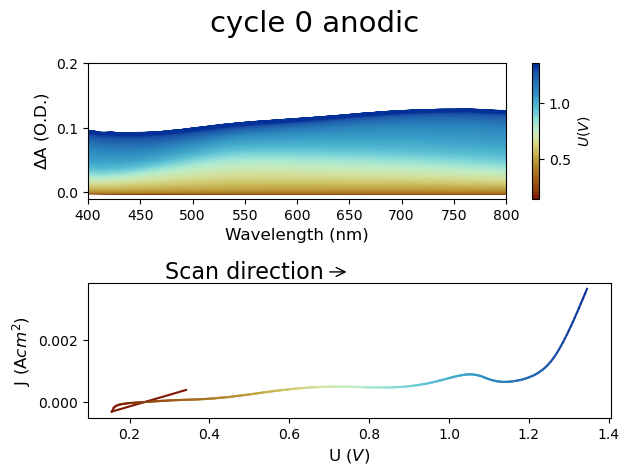

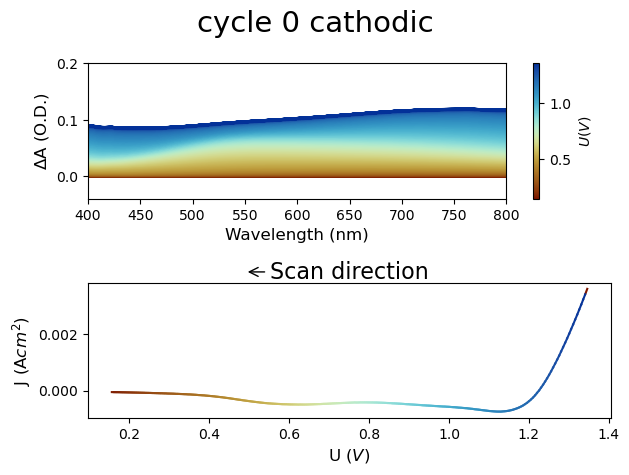

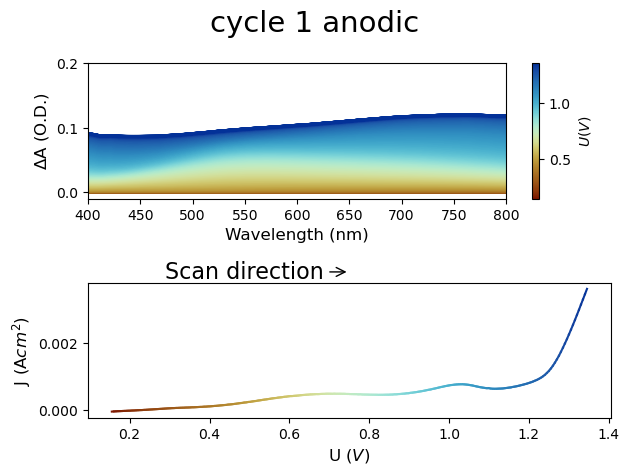

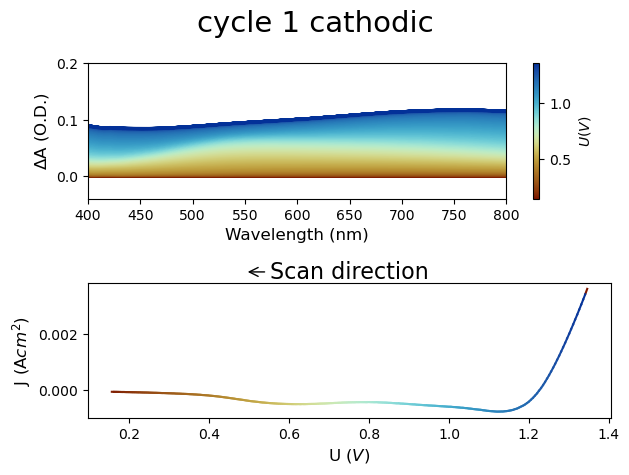

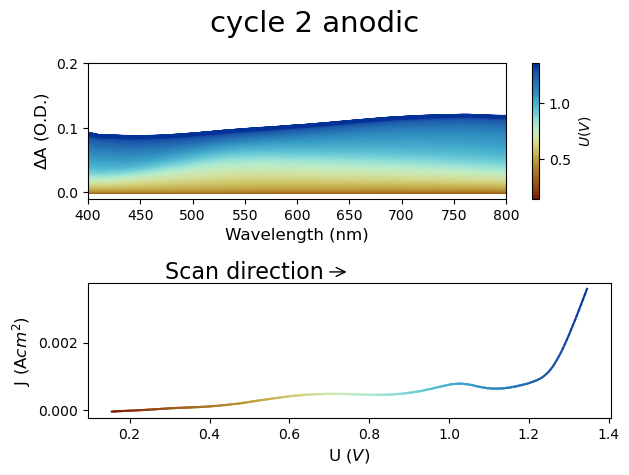

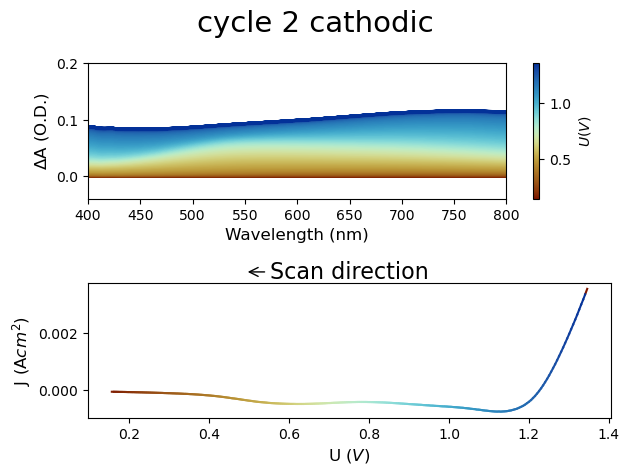

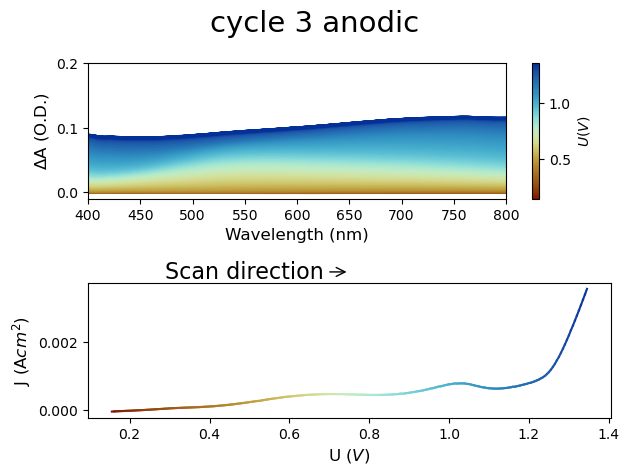

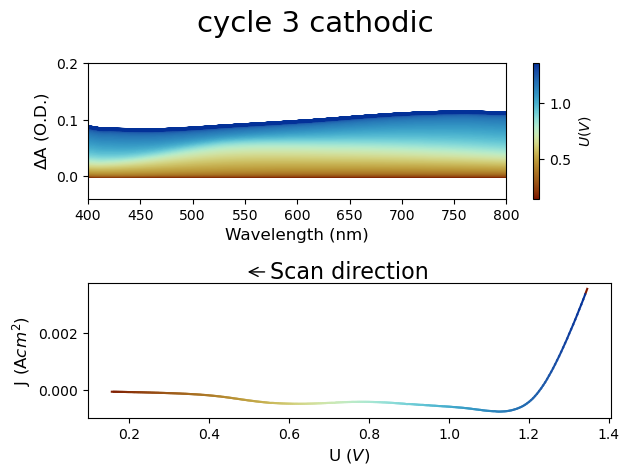

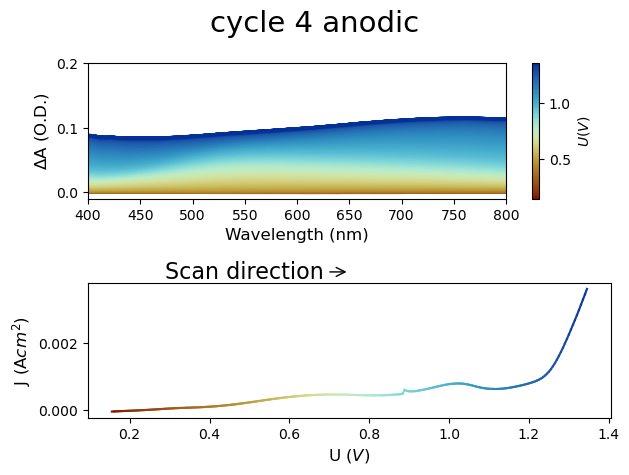

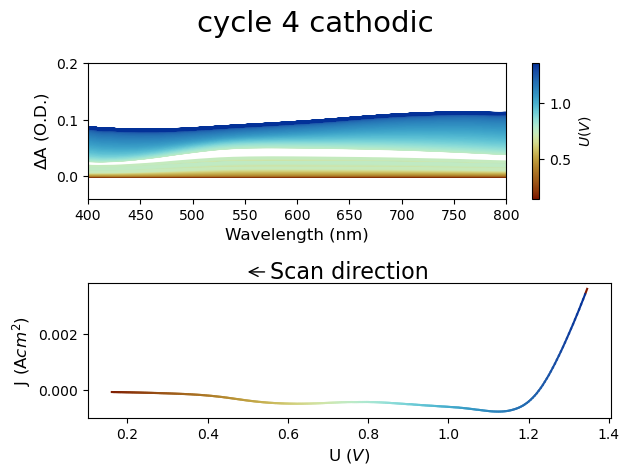

In [12]:

for key, value in spec1.CV_scans.items():

        for key2, value2 in value.items():
            CV=spec1.CV_scans[key][key2]
            if key2 == 'anodic':
                test, ref =calculateDOD(spec1, key, key2, -2, 21)
                Co_plot_DOD_and_CV(test,
                                      CV,
                                        Title=f'cycle {key} {key2}',
                                          y_max=0.2, y_min=-0.01,
                                            x_min=400, x_max=800,
                                              reference_potential=f"$ {ref}V_{{Ag/AgCl}}$",
                                                scan_direction=key2,
                                                  cmap_option=cmc.roma)
            elif key2 == 'cathodic':
                test, ref =calculateDOD(spec1, key, key2, -2, 21)
                Co_plot_DOD_and_CV(test,
                                      CV,
                                        Title=f'cycle {key} {key2}',
                                          y_max=0.2, y_min=-0.04,
                                            x_min=400, x_max=800,
                                              reference_potential=f"$ {ref}V_{{Ag/AgCl}}$",
                                                scan_direction=key2,
                                                  cmap_option=cmc.roma)
            #plt.savefig(os.path.join(full_output_path, f'Cycle_{key}_{key2}.png'))
            plt.close() 


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Wavelength (nm)', ylabel='$\\Delta$A (O.D. vs $ -0.2V_{Ag/AgCl}$)'>)

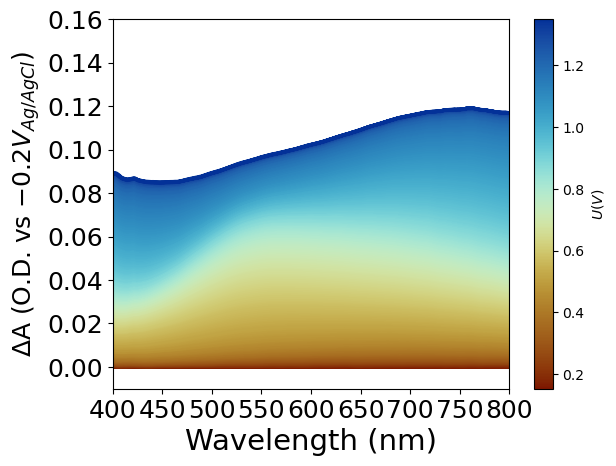

In [13]:
data, ref=calculateDOD(spec1, 0, 'cathodic', -0.2, 21)
plot_DOD(data, y_max=0.16, y_min=-0.01, x_min=400, x_max=800, reference_potential=f"$ {ref}V_{{Ag/AgCl}}$")

In [49]:
pd.read_parquet('spectra_calibrated.parquet')

,t (s),U (V),cycle,direction,J (A),399.0,400.0,401.0,402.0,403.0,...,932.0,933.0,934.0,935.0,936.0,937.0,938.0,939.0,940.0,941.0
0,0.015,0.151,0.0,anodic,0.000196,1874425.75,1.743671e+06,1803686.55,1877249.85,1936551.375,...,1449116.5,1.435604e+06,1422407.35,1410819.55,1397129.3,1386571.375,1376253.9,1371432.65,1353590.05,1.342111e+06
1,0.046,0.153,0.0,anodic,-0.000096,1874670.50,1.743370e+06,1804365.40,1876786.80,1935548.125,...,1449384.4,1.435717e+06,1422381.90,1411216.00,1396964.5,1388192.500,1376920.2,1369931.50,1354327.30,1.341497e+06
2,0.066,0.154,0.0,anodic,-0.000210,1874910.50,1.743881e+06,1803983.40,1877827.10,1936166.000,...,1450461.8,1.436793e+06,1422735.90,1411259.20,1396965.6,1387555.500,1376732.5,1372063.90,1354480.70,1.342927e+06
3,0.087,0.155,0.0,anodic,-0.000278,1876664.50,1.744037e+06,1806151.40,1879192.00,1935975.125,...,1449313.2,1.437595e+06,1423999.00,1412848.00,1397261.4,1387467.500,1378645.8,1372121.50,1355907.50,1.341461e+06
4,0.107,0.156,0.0,anodic,-0.000303,1873412.00,1.744791e+06,1804664.80,1878737.70,1936144.500,...,1450526.9,1.437430e+06,1422128.70,1411202.50,1396893.8,1387324.875,1377084.9,1372294.40,1354094.80,1.342636e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11992,216.089,1.346,4.0,cathodic,0.003623,1489303.50,1.387748e+06,1436125.70,1494570.80,1540118.250,...,1096054.0,1.086495e+06,1076718.50,1068761.30,1056752.5,1050234.750,1042532.7,1039595.90,1025300.30,1.017304e+06
11993,216.069,1.347,4.0,cathodic,0.003671,1493108.00,1.386671e+06,1435185.60,1494408.30,1541105.625,...,1095693.7,1.086848e+06,1077209.60,1067581.10,1057217.5,1049977.250,1042287.4,1038181.60,1025206.10,1.015784e+06
11994,216.048,1.348,4.0,cathodic,0.003720,1493643.00,1.388120e+06,1435257.70,1495325.40,1539990.500,...,1096792.7,1.086518e+06,1076412.80,1066656.40,1058225.7,1050703.875,1041520.0,1039459.00,1025307.30,1.017725e+06
11995,216.028,1.349,4.0,cathodic,0.003761,1491883.50,1.387937e+06,1436900.30,1494286.50,1540710.000,...,1097025.3,1.087283e+06,1077283.80,1068639.20,1057217.5,1049982.375,1042209.3,1039633.40,1025991.10,1.017043e+06
